In [1]:
# %% [markdown]
# Refactored driver for the tran inclusions experiment.
# 
# This script wires together modular components from ``notebooks/tran_inclusions/``.
# The original ``explore_tran_inclusions_pseudo.py`` remains as a backup reference.
# """
# 
# # %% [markdown]
# # # Tran Inclusions Experiment
# # 
# # This notebook drives the experiment for lifting transport inclusions using spatio-temporal geometric harmonics on TCDM embeddings.

In [2]:
import sys
import os
import pickle
from pathlib import Path
from typing import Optional, Dict, List, Any, Callable

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Caching Infrastructure ---
CACHE_DIR = Path("../data/cache_tran_inclusions")
CACHE_DIR.mkdir(parents=True, exist_ok=True)
FORCE_RECOMPUTE = False  # Set to True to invalidate all caches

def load_or_compute(
    cache_name: str,
    compute_fn: Callable[[], Any],
    force: bool = False
) -> Any:
    """Load result from cache if available, otherwise compute and save."""
    cache_path = CACHE_DIR / f"{cache_name}.pkl"
    if not force and not FORCE_RECOMPUTE and cache_path.exists():
        print(f"Loading {cache_name} from cache: {cache_path}")
        try:
            with open(cache_path, "rb") as f:
                return pickle.load(f)
        except Exception as e:
            print(f"Failed to load cache {cache_name}: {e}. Recomputing...")
    
    print(f"Computing {cache_name}...")
    result = compute_fn()
    
    print(f"Saving {cache_name} to cache: {cache_path}")
    with open(cache_path, "wb") as f:
        pickle.dump(result, f)
    return result

# Make repository root importable when executing from the notebooks directory
try:
    sys.path.append(str(Path(__file__).resolve().parent.parent))
except NameError:
    import os
    sys.path.append(os.path.abspath(".."))


from diffmap.lifting import compute_lift_metrics, print_metric_table
from mmsfm.viz import plot_field_comparisons, plot_error_statistics
from mmsfm.data_utils import pca_decode, to_images


from tran_inclusions.config import LiftingConfig, PseudoDataConfig  # type: ignore  # noqa: E402
from tran_inclusions.data_prep import (  # type: ignore  # noqa: E402
    compute_bandwidth_statistics,
    load_tran_inclusions_data,
)
from tran_inclusions.tc_embeddings import build_time_coupled_embeddings  # type: ignore  # noqa: E402
from tran_inclusions.pseudo_data import choose_pseudo_times_per_interval  # type: ignore  # noqa: E402
from tran_inclusions.interpolation import build_dense_latent_trajectories, sample_latent_at_times  # type: ignore  # noqa: E402
from tran_inclusions.lifting import fit_lifting_models, lift_pseudo_latents  # type: ignore  # noqa: E402
from tran_inclusions.metrics import evaluate_interpolation_at_observed_times  # type: ignore  # noqa: E402
from tran_inclusions.viz import visualize_fractional_pca_intervals, plot_latent_trajectories_comparison  # type: ignore  # noqa: E402

check syl solve
True
here
True
6.250772782703453e-14
Use algebraic Stiefel log, metric alpha =  -0.0
dist 3.7699111843077606
NORM TEST1: 0.0
NORM TEST2: 5.814272674431464e-13
NORM TEST3: 6.958843223880962e-15


In [3]:
# Parameters
data_path = Path("../data/tran_inclusions.npz")
epsilon_selection_mode = 'first_local_minimum'
gh_max_modes = 300

In [4]:
(
    times_arr,
    held_out_indices,
    held_out_times,
    all_frames,
    components,
    mean_vec,
    explained_variance,
    is_whitened,
    whitening_epsilon,
    resolution,
    raw_marginals,
    held_out_marginals,
) = load_tran_inclusions_data(data_path)

print(f"Loaded data: {all_frames.shape} (Time, Samples, PCA_Comps)")
print(f"Time points: {times_arr}")

# %% [markdown]
# ## Pseudo-Time Selection

Loaded data: (7, 5000, 376) (Time, Samples, PCA_Comps)
Time points: [0.11111111 0.22222222 0.44444444 0.55555556 0.66666667 0.88888889
 1.        ]


In [5]:
tc_k = 12
alpha = 1.0
beta = -0.2
use_variable_bandwidth = False

pseudo_config = PseudoDataConfig(
    n_dense=20,
    n_pseudo_per_interval=3,
    eta_fuse=0.5,
    alpha_grid=None,
)

pseudo_times, alphas_per_interval = choose_pseudo_times_per_interval(
    times_arr,
    n_per_interval=pseudo_config.n_pseudo_per_interval,
    include_endpoints=False,
    alpha_grid=pseudo_config.alpha_grid,
)
print(f"Planned pseudo times (raw union): {pseudo_times}")

# %% [markdown]
# ## Time-Coupled Embeddings

Planned pseudo times (raw union): [0.13888889 0.16666667 0.19444444 0.27777778 0.33333333 0.38888889
 0.47222222 0.5        0.52777778 0.58333333 0.61111111 0.63888889
 0.72222222 0.77777778 0.83333333 0.91666667 0.94444444 0.97222222]


In [6]:
# %%
def compute_tc_embeddings():
    bandwidth_stats = compute_bandwidth_statistics(all_frames)
    base_epsilons = bandwidth_stats['median']
    epsilon_scales = np.geomspace(0.01, 0.2, num=32)
    semigroup_sample_size = min(1024, all_frames.shape[1])
    semigroup_rng_seed = 0

    return build_time_coupled_embeddings(
        all_frames=all_frames,
        times_arr=times_arr,
        tc_k=tc_k,
        alpha=alpha,
        beta=beta,
        use_variable_bandwidth=use_variable_bandwidth,
        base_epsilons=base_epsilons,
        scales=epsilon_scales,
        sample_size=semigroup_sample_size,
        rng_seed=semigroup_rng_seed,
        epsilon_selection=epsilon_selection_mode,
    )

tc_result, tc_embeddings_time, selected_epsilons, kde_bandwidths, semigroup_df = load_or_compute(
    "tc_embeddings",
    compute_tc_embeddings
)

# %% [markdown]
# ## Pseudo-Data Generation (Augmentation)

Computing tc_embeddings...


Chosen epsilons (first local minimum SGE):
[55.38767118 50.69228726 42.17883192 34.94993389 27.00551257 16.20825465
  6.60975585]
Reference (min SGE) epsilons:
[464.22092764 385.73121702 320.95005078 292.92603185 186.56347199
  83.792339     6.60975585]
KDE bandwidths used (variable bandwidth only): [nan nan nan nan nan nan nan]
Time-coupled embeddings tensor: (7, 5000, 12)
Saving tc_embeddings to cache: ../data/cache_tran_inclusions/tc_embeddings.pkl


Elbow-selected epsilons (with min-SGE reference):


time  epsilon_elbow  semigroup_error_elbow  epsilon_min  \
0  0.111111      45.653669               0.068044   464.220928   
1  0.222222      46.022815               0.063644   385.731217   
2  0.444444      38.293568               0.066665   320.950051   
3  0.555556      31.730554               0.071873   292.926032   
4  0.666667      27.005513               0.068542   186.563472   
5  0.888889      14.715247               0.074827    83.792339   
6  1.000000       5.448137               0.065307     6.609756   

   semigroup_error_min  kde_bandwidth  
0             0.011551            NaN  
1             0.012889            NaN  
2             0.015353            NaN  
3             0.016647            NaN  
4             0.022210            NaN  
5             0.039753            NaN  
6             0.060841            NaN

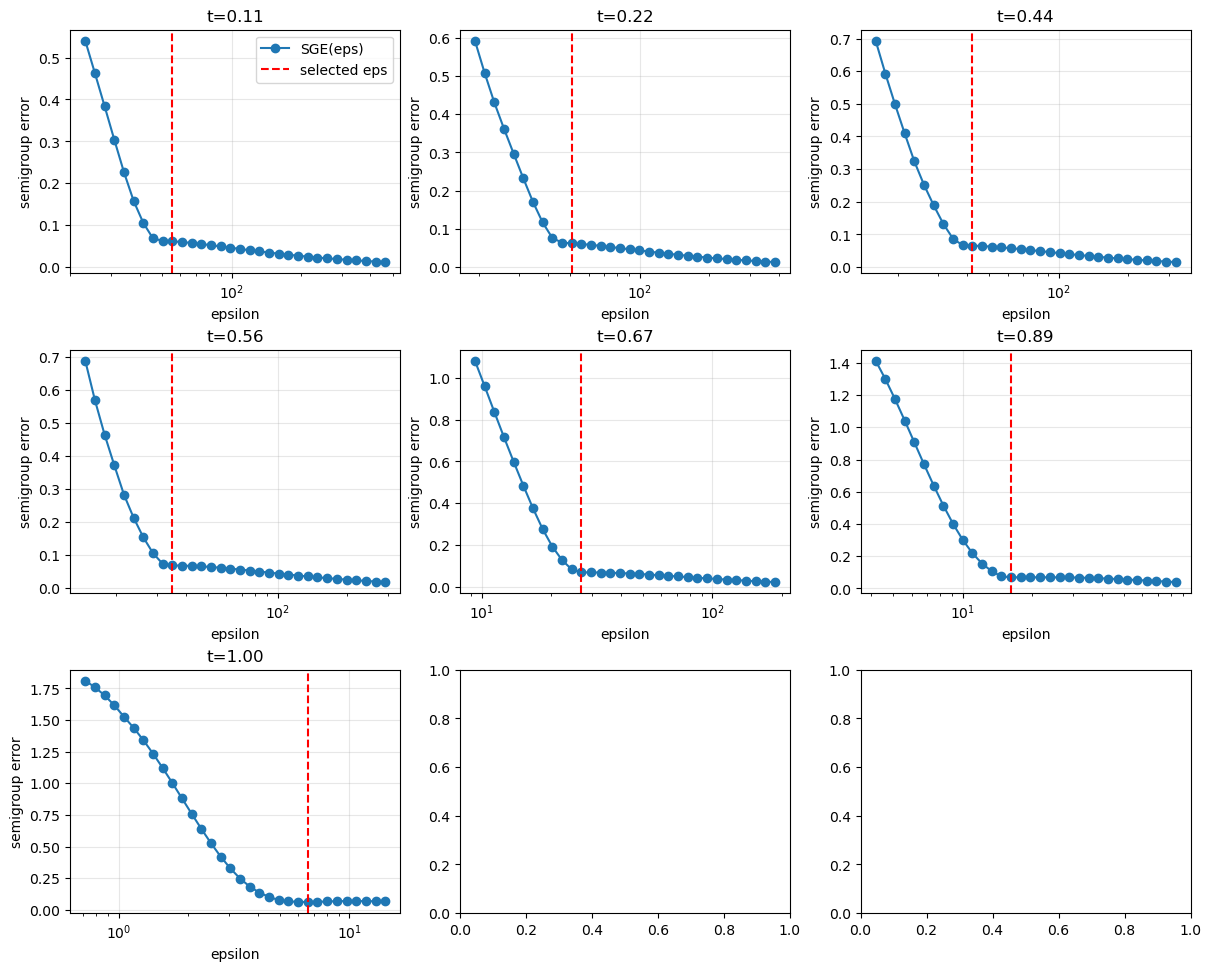

In [15]:
# --- Semigroup bandwidth diagnostics ---
from IPython.display import display

if semigroup_df is None or len(getattr(semigroup_df, "index", [])) == 0:
    print("Semigroup diagnostics unavailable.")
else:
    semigroup_best = (
        semigroup_df.sort_values("semigroup_error")
        .groupby("time_index")
        .first()
        .reset_index(drop=True)
    )
    semigroup_best = semigroup_best[
        ["time", "epsilon", "semigroup_error", "kde_bandwidth"]
    ]

    # Elbow summary (if available)
    if "epsilon_elbow" in semigroup_df.columns:
        elbow_rows = []
        for idx in sorted(semigroup_df["time_index"].unique()):
            subset = semigroup_df[semigroup_df["time_index"] == idx]
            eps_elb = float(subset["epsilon_elbow"].iloc[0])
            row = subset.loc[(subset["epsilon"].sub(eps_elb)).abs().idxmin()]
            elbow_rows.append(
                {
                    "time": float(row["time"]),
                    "epsilon_elbow": eps_elb,
                    "semigroup_error_elbow": float(row["semigroup_error"]),
                }
            )
        elbow_df = pd.DataFrame(elbow_rows)
        summary = elbow_df.merge(
            semigroup_best.rename(
                columns={
                    "epsilon": "epsilon_min",
                    "semigroup_error": "semigroup_error_min",
                }
            ),
            on="time",
            how="left",
        )
        print("Elbow-selected epsilons (with min-SGE reference):")
        display(summary)
    else:
        print("Semigroup-selected epsilons (min SGE):")
        display(semigroup_best)

    unique_times = semigroup_df["time_index"].unique()
    n_rows = int(np.ceil(len(unique_times) / 3)) if len(unique_times) else 1
    n_cols = min(3, max(1, len(unique_times)))
    fig, axes = plt.subplots(
        n_rows,
        n_cols,
        figsize=(4 * n_cols, 3.2 * n_rows),
        squeeze=False,
        constrained_layout=True,
    )

    for ax, idx in zip(axes.flat, unique_times):
        subset = semigroup_df[semigroup_df["time_index"] == idx].sort_values(
            "epsilon"
        )
        ax.plot(subset["epsilon"], subset["semigroup_error"], "o-", label="SGE(eps)")
        
        if 'selected_epsilons' in locals() and selected_epsilons is not None:
            selected_eps = selected_epsilons[int(idx)]
        elif "epsilon_elbow" in subset.columns and epsilon_selection_mode == 'elbow':
            selected_eps = subset["epsilon_elbow"].iloc[0]
        else:
            best_row = subset.loc[subset["semigroup_error"].idxmin()]
            selected_eps = best_row["epsilon"]

        ax.axvline(
            selected_eps,
            color="r",
            linestyle="--",
            label="selected eps",
        )
        ax.set_xscale("log")
        ax.set_title(f"t={subset['time'].iloc[0]:.2f}")
        ax.set_xlabel("epsilon")
        ax.set_ylabel("semigroup error")
        ax.grid(alpha=0.3)
    if axes.size:
        axes.flat[0].legend()
    plt.show()

In [16]:
# %%
def compute_pseudo_data():
    entries = []
    for idx, t_val in enumerate(times_arr):
        entries.append(
            {
                "time": float(t_val),
                "kind": "observed",
                "interval_index": idx,
                "alpha": 0.0,
                "source_time": float(t_val),
                "target_time": float(t_val),
                "eta": pseudo_config.eta_fuse,
                "aug_index": idx,
            }
        )
    meta = {
        "entries": entries,
        "alphas_per_interval": alphas_per_interval,
        "eta": pseudo_config.eta_fuse,
    }
    return times_arr, all_frames, meta

times_aug, frames_aug, pseudo_meta = load_or_compute(
    "pseudo_data",
    compute_pseudo_data
)
pseudo_entries = [entry for entry in pseudo_meta['entries'] if entry['kind'] == 'pseudo']
print(
    f"Augmented dataset: {len(times_aug)} scales "
    f"({len(times_arr)} observed, {len(pseudo_entries)} pseudo)."
)

# %% [markdown]
# ## Latent Interpolation

Loading pseudo_data from cache: ../data/cache_tran_inclusions/pseudo_data.pkl
Augmented dataset: 7 scales (7 observed, 0 pseudo).


In [17]:
# %%
def compute_interpolation():
    return build_dense_latent_trajectories(
        tc_result,
        times_train=times_arr,
        tc_embeddings_time=tc_embeddings_time,
        n_dense=pseudo_config.n_dense,
        frechet_mode=pseudo_config.frechet_mode,
    )

interpolation = load_or_compute(
    "interpolation",
    compute_interpolation
)

# 2. CRITICAL STEP: PERMANENTLY update the reference embeddings to the aligned versions
if interpolation.tc_embeddings_aligned is not None:
    print("Updating tc_embeddings_time to aligned embeddings for visualization and downstream tasks.")
    tc_embeddings_time = interpolation.tc_embeddings_aligned
else:
    print("WARNING: Aligned embeddings not found in interpolation result. Using original embeddings.")

# %% [markdown]
# ## Lifting Model Training

Computing interpolation...


Use algebraic Stiefel log, metric alpha =  1e-08
Use algebraic Stiefel log, metric alpha =  1e-08
Use algebraic Stiefel log, metric alpha =  1e-08
Use algebraic Stiefel log, metric alpha =  1e-08
Use algebraic Stiefel log, metric alpha =  1e-08
Use algebraic Stiefel log, metric alpha =  1e-08
Use algebraic Stiefel log, metric alpha =  1e-08
Use algebraic Stiefel log, metric alpha =  1e-08
p-Shooting unified method did not converge
Use algebraic Stiefel log, metric alpha =  1e-08
p-Shooting unified method did not converge
Use algebraic Stiefel log, metric alpha =  1e-08
p-Shooting unified method did not converge
Use algebraic Stiefel log, metric alpha =  1e-08
p-Shooting unified method did not converge
Use algebraic Stiefel log, metric alpha =  1e-08
p-Shooting unified method did not converge
Use algebraic Stiefel log, metric alpha =  1e-08
p-Shooting unified method did not converge
Use algebraic Stiefel log, metric alpha =  1e-08
p-Shooting unified method did not converge
Use algebraic

Use algebraic Stiefel log, metric alpha =  1e-08
Use algebraic Stiefel log, metric alpha =  1e-08
Use algebraic Stiefel log, metric alpha =  1e-08
Use algebraic Stiefel log, metric alpha =  1e-08
Use algebraic Stiefel log, metric alpha =  1e-08
Use algebraic Stiefel log, metric alpha =  1e-08
Use algebraic Stiefel log, metric alpha =  1e-08
Use algebraic Stiefel log, metric alpha =  1e-08
p-Shooting unified method did not converge
Use algebraic Stiefel log, metric alpha =  1e-08
p-Shooting unified method did not converge
Use algebraic Stiefel log, metric alpha =  1e-08
p-Shooting unified method did not converge
Use algebraic Stiefel log, metric alpha =  1e-08
p-Shooting unified method did not converge
Use algebraic Stiefel log, metric alpha =  1e-08
p-Shooting unified method did not converge
Use algebraic Stiefel log, metric alpha =  1e-08
p-Shooting unified method did not converge
Use algebraic Stiefel log, metric alpha =  1e-08
p-Shooting unified method did not converge
Use algebraic

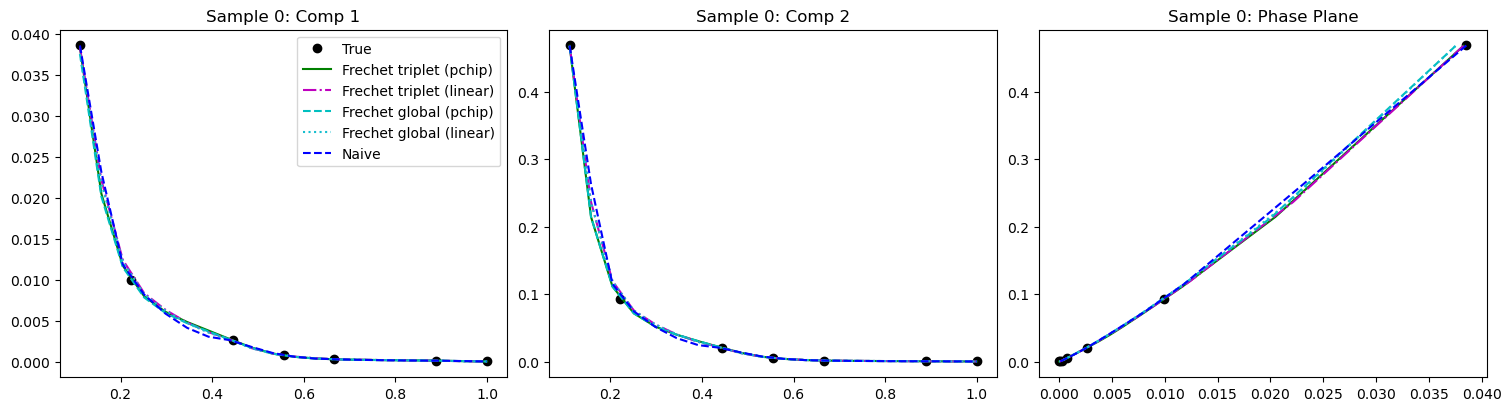

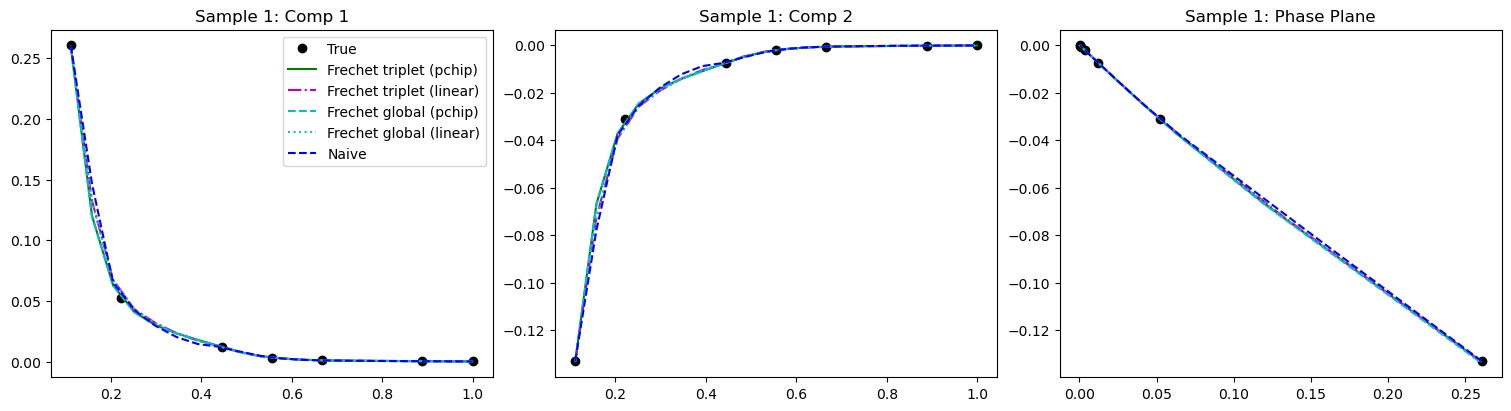

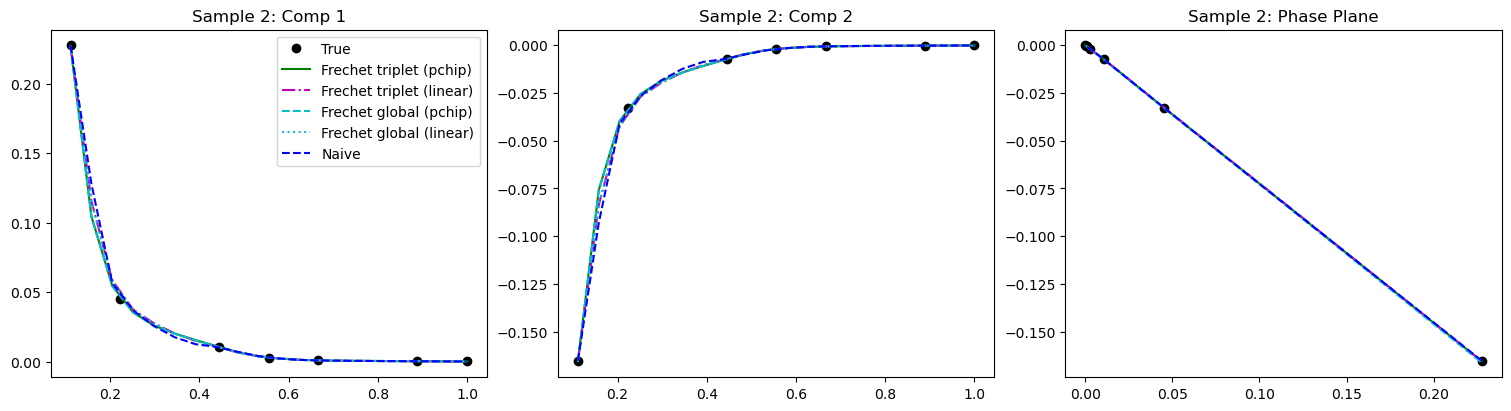

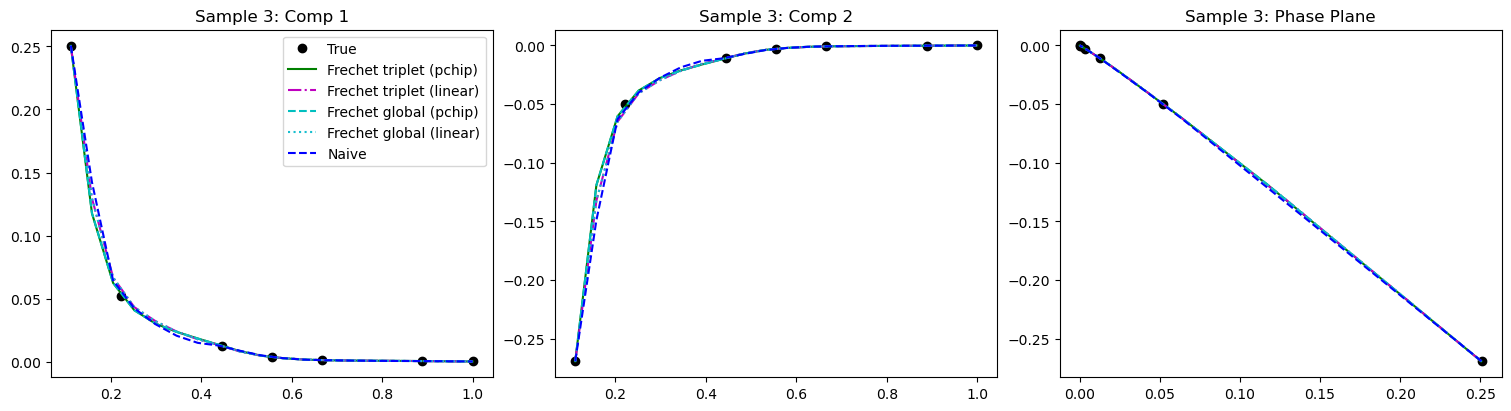

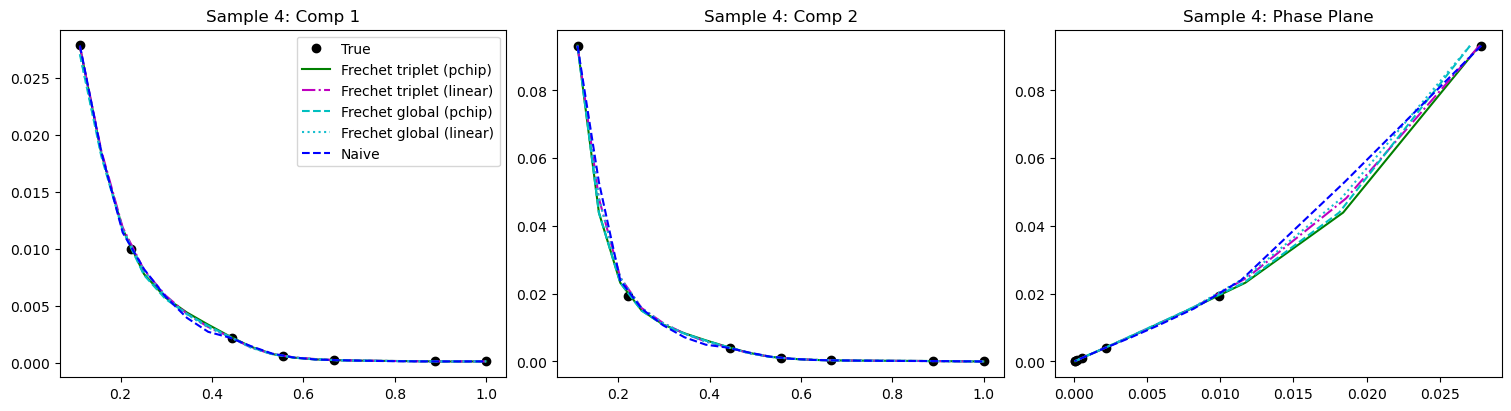

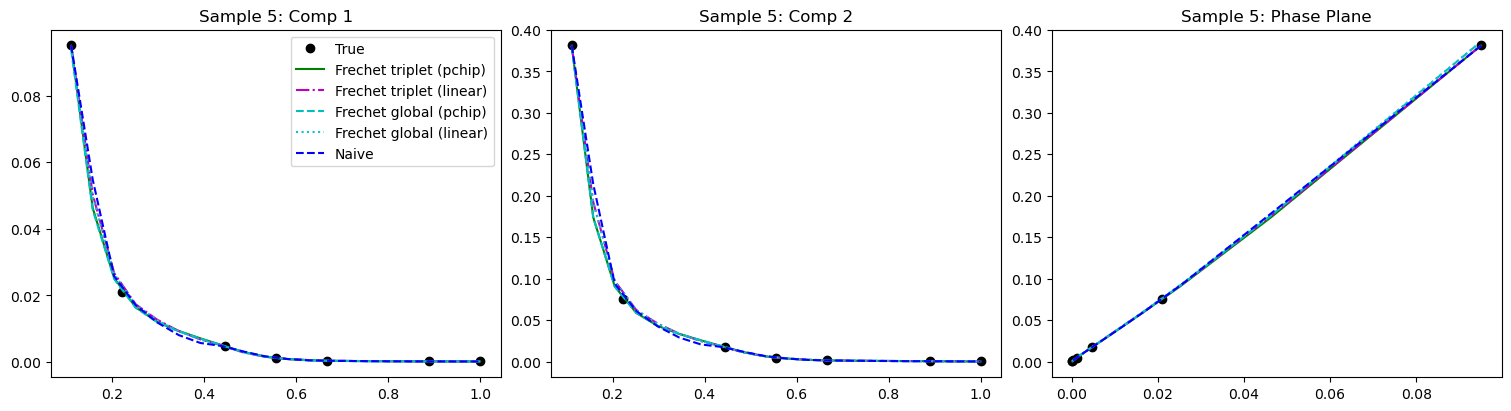

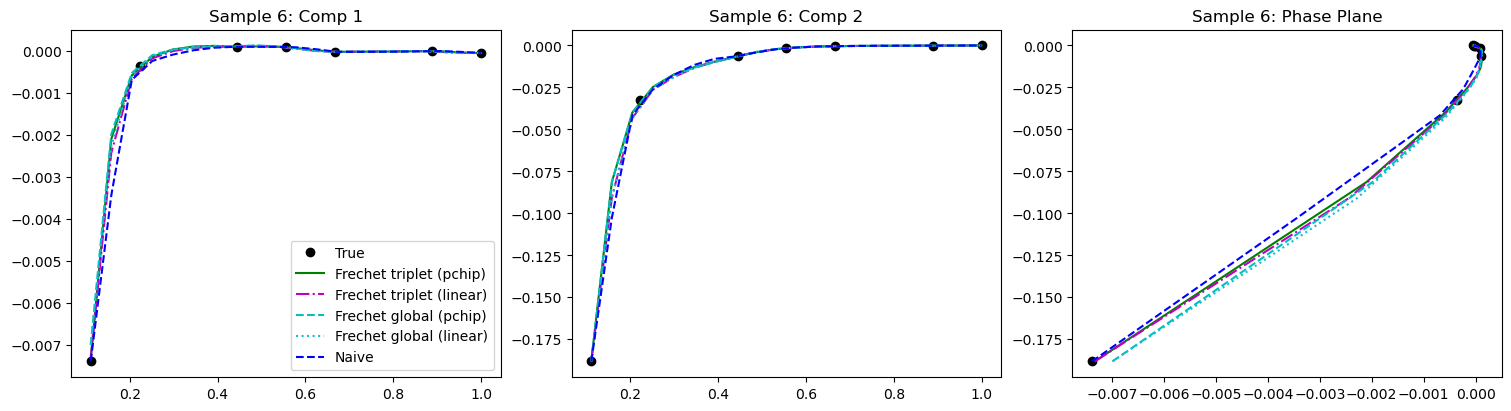

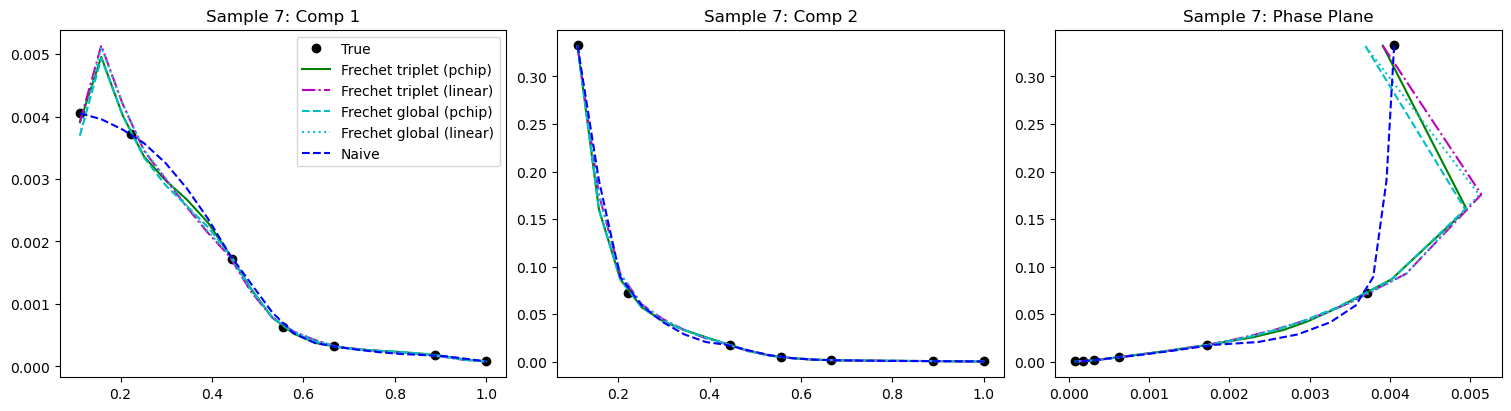

In [18]:
# Compute global Frechet mean interpolation for comparison
interpolation_frechet_global = build_dense_latent_trajectories(
    tc_result,
    times_train=times_arr,
    tc_embeddings_time=tc_embeddings_time,
    n_dense=pseudo_config.n_dense,
    frechet_mode='global',
)

# Visualize the latent trajectories for a few samples
sample_indices_to_plot = list(range(pseudo_config.n_samples_vis))
plot_latent_trajectories_comparison(
    times_train=times_arr,
    tc_embeddings_time=tc_embeddings_time,
    interpolation_triplet=interpolation,
    interpolation_global=interpolation_frechet_global,
    sample_indices=sample_indices_to_plot,
)

In [19]:
# %%
lifting_config = LiftingConfig(
    holdout_time=times_arr[1] if len(times_arr) > 1 else times_arr[0],
    gh_max_modes=gh_max_modes,
    gh_energy_threshold=0.99,
    gh_epsilon_grid_size=32,
    gh_ridge=1e-4,
    use_continuous_gh=True,
)

def compute_lifting_models():
    return fit_lifting_models(
        tc_embeddings_time,
        all_frames,
        times_arr,
        lifting_config,
        trajectory=tc_result,
    )

models, lifting_metadata = load_or_compute(
    "lifting_models",
    compute_lifting_models,
    force=True,
)

# %% [markdown]
# ## Semigroup Error Diagnostics for Continuous GH

Computing lifting_models...
Training pairs collected: macro (30000, 12), micro (30000, 376)


Use algebraic Stiefel log, metric alpha =  1e-08
Use algebraic Stiefel log, metric alpha =  1e-08
Use algebraic Stiefel log, metric alpha =  1e-08
Use algebraic Stiefel log, metric alpha =  1e-08
Use algebraic Stiefel log, metric alpha =  1e-08
Use algebraic Stiefel log, metric alpha =  1e-08
Use algebraic Stiefel log, metric alpha =  1e-08
Saving lifting_models to cache: ../data/cache_tran_inclusions/lifting_models.pkl


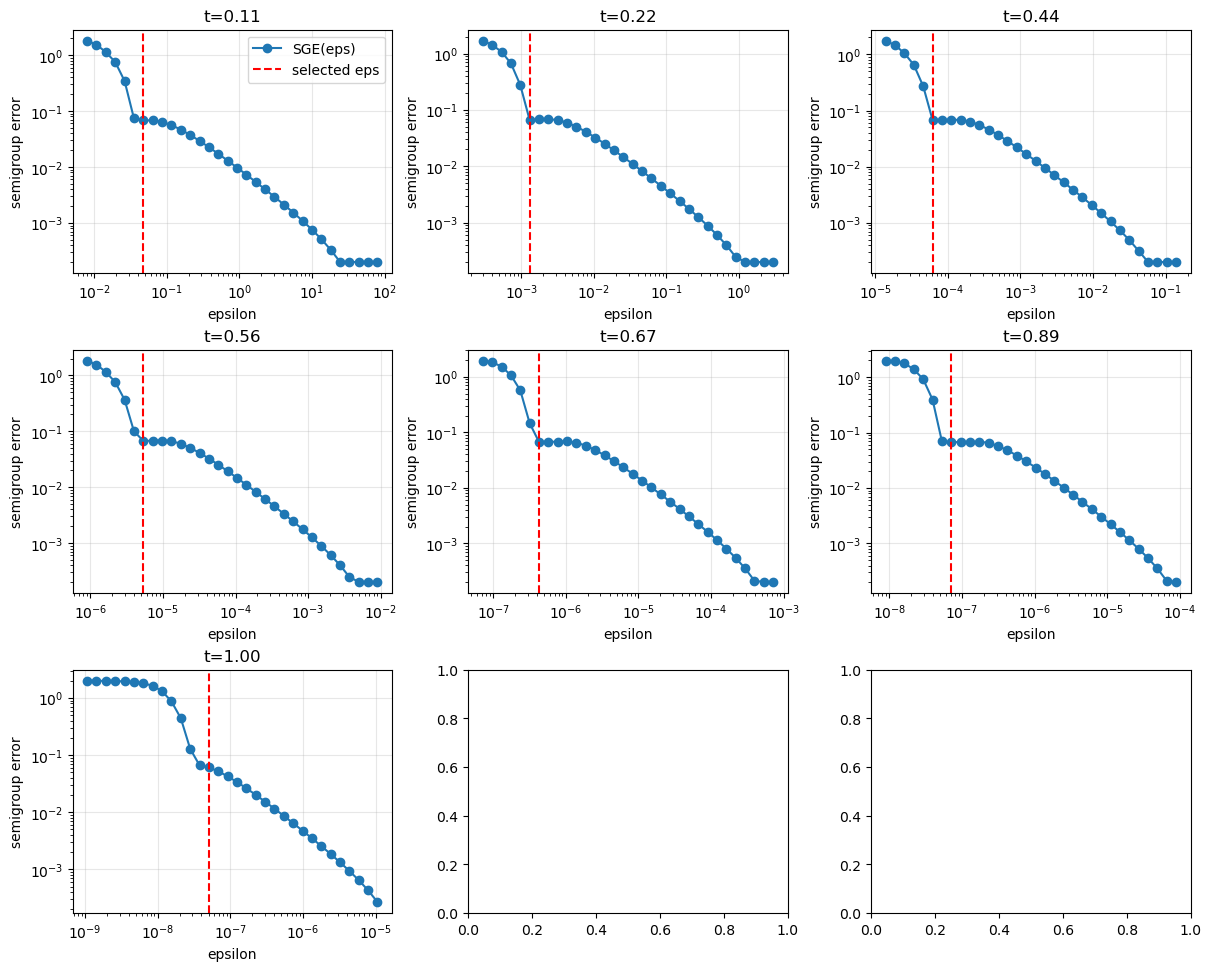

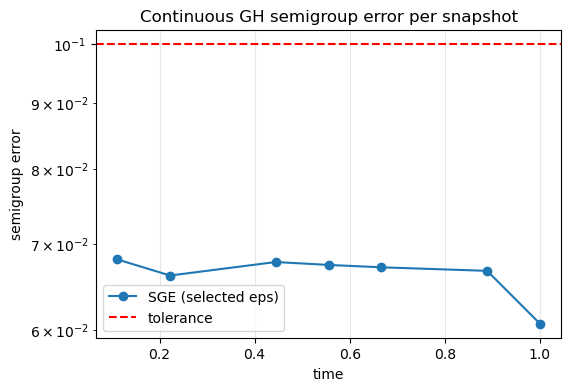

In [20]:
def plot_cgh_semigroup_errors():
    cgh_model = getattr(models, "continuous_gh", None)
    if cgh_model is None or getattr(cgh_model, "_result", None) is None:
        print("Continuous GH model unavailable; skipping semigroup error plot.")
        return
    res = cgh_model._result
    if not hasattr(res, "semigroup_errors"):
        print("Semigroup errors not recorded; skipping plot.")
        return

    eps_grid = getattr(res, "epsilon_grid", None)
    sge_grid = getattr(res, "semigroup_error_grid", None)
    if eps_grid is not None and sge_grid is not None:
        eps_grid = np.asarray(eps_grid)
        sge_grid = np.asarray(sge_grid)
        n_times = min(eps_grid.shape[0], sge_grid.shape[0])
        if n_times:
            n_rows = int(np.ceil(n_times / 3))
            n_cols = min(3, n_times)
            fig, axes = plt.subplots(
                n_rows,
                n_cols,
                figsize=(4 * n_cols, 3.2 * n_rows),
                squeeze=False,
                constrained_layout=True,
            )
            for ax, idx in zip(axes.flat, range(n_times)):
                ax.plot(eps_grid[idx], sge_grid[idx], "o-", label="SGE(eps)")
                ax.axvline(
                    res.epsilons[idx],
                    color="r",
                    linestyle="--",
                    label="selected eps",
                )
                ax.set_xscale("log")
                ax.set_yscale("log")
                ax.set_title(f"t={res.times[idx]:.2f}")
                ax.set_xlabel("epsilon")
                ax.set_ylabel("semigroup error")
                ax.grid(alpha=0.3)
            if axes.size:
                axes.flat[0].legend()
            plt.show()
        else:
            print("Semigroup error grid appears empty; skipping epsilon sweep plots.")
    else:
        print("Semigroup error grid unavailable; skipping epsilon sweep plots.")

    plt.figure(figsize=(6, 4))
    plt.plot(res.times, res.semigroup_errors, "o-", label="SGE (selected eps)")
    plt.axhline(getattr(cgh_model, "semigroup_tolerance", 0.1), color="r", linestyle="--", label="tolerance")
    plt.yscale("log")
    plt.xlabel("time")
    plt.ylabel("semigroup error")
    plt.title("Continuous GH semigroup error per snapshot")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.show()

plot_cgh_semigroup_errors()

# %% [markdown]
# ## Evaluation

In [21]:
metrics = evaluate_interpolation_at_observed_times(
    tc_embeddings_time=tc_embeddings_time,
    all_frames=all_frames,
    times_arr=times_arr,
    interpolation=interpolation,
    models=models,
    lifting_metadata=lifting_metadata,
    config=lifting_config,
    components=components,
    mean_vec=mean_vec,
    explained_variance=explained_variance,
    is_whitened=is_whitened,
    whitening_epsilon=whitening_epsilon,
    resolution=resolution,
)
print("Evaluation metrics:", metrics)



Evaluating interpolation at observed times...


Embedding MSE per time: [1.03076257e-07 3.57741236e-08 1.64440524e-10 2.17761669e-11
 2.88356991e-12 4.60896063e-12 5.27740404e-18]
Mean Embedding MSE: 1.9863441355895496e-08
Lifting pseudo latents with batched time-local neighbour selection...
Evaluation metrics: {'convex': {'per_time_mse': array([0.04020645, 0.07086857, 0.02602932, 0.02327312, 0.01307394,
       0.00466843, 0.00058172]), 'mean_mse': 0.02552879277464392}, 'cgh': {'per_time_mse': array([1.03827281e-01, 1.88439041e-01, 1.51647303e-01, 6.57803895e-02,
       4.09526460e-02, 1.71951698e-02, 9.04239774e+07]), 'mean_mse': 12917711.141876837}, 'embedding_mse': array([1.03076257e-07, 3.57741236e-08, 1.64440524e-10, 2.17761669e-11,
       2.88356991e-12, 4.60896063e-12, 5.27740404e-18])}


Reloaded mmsfm.viz


Lifting pseudo latents with batched time-local neighbour selection...
--- Hold-out t=0.333 ---
method             RMSE     RelErr        MAE     |Δvol|       Δvol
-------------------------------------------------------------------
convex        8.813e-02  1.914e-03  6.812e-02  2.603e-03  4.646e-04
cgh           3.442e-01  7.458e-03  2.732e-01  1.023e-02 -5.012e-04


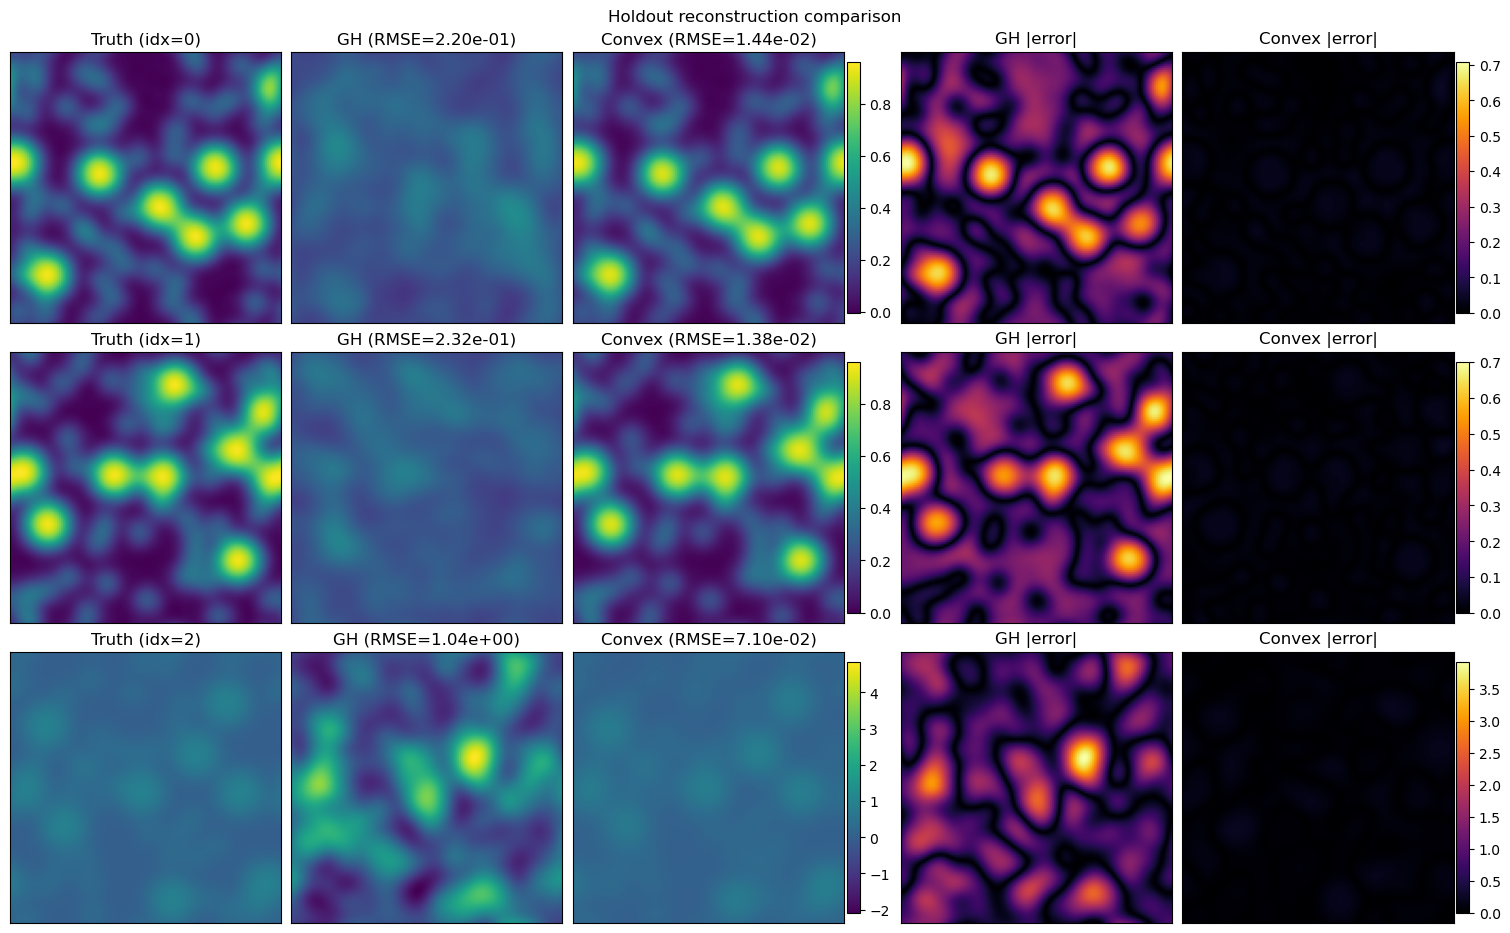

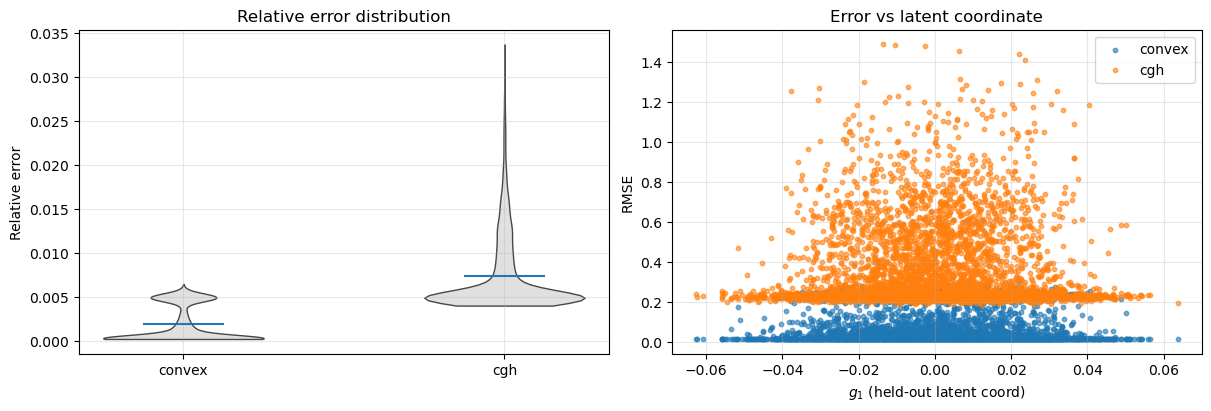

--- Hold-out t=0.778 ---
method             RMSE     RelErr        MAE     |Δvol|       Δvol
-------------------------------------------------------------------
convex        1.112e-01  2.808e-03  9.019e-02  6.548e-03 -8.429e-05
cgh           1.227e-01  3.098e-03  9.948e-02  6.562e-03 -1.537e-04


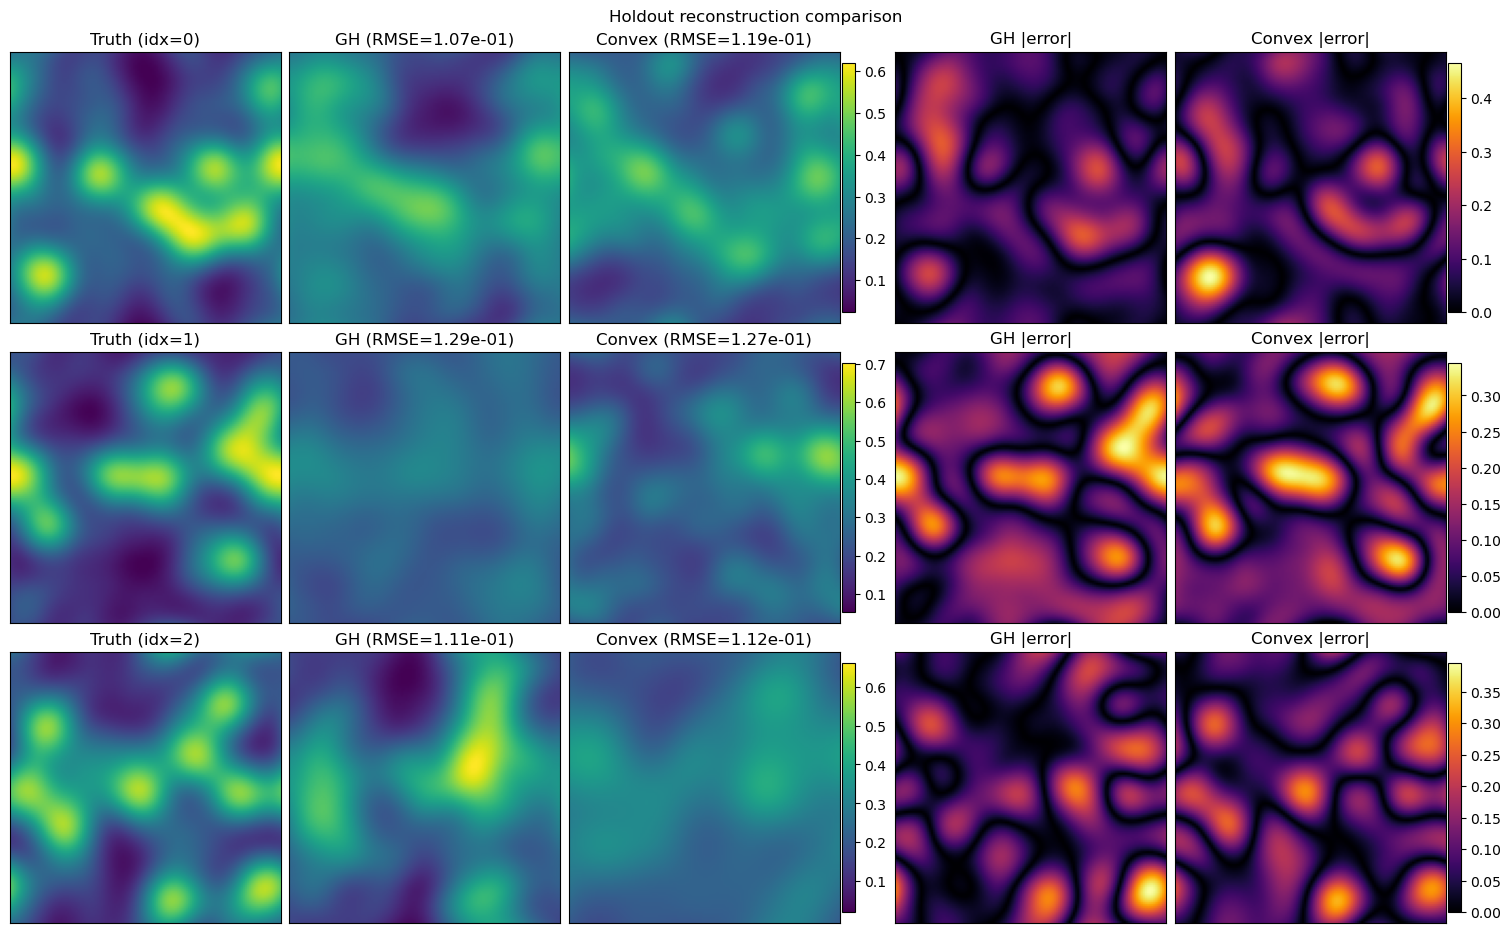

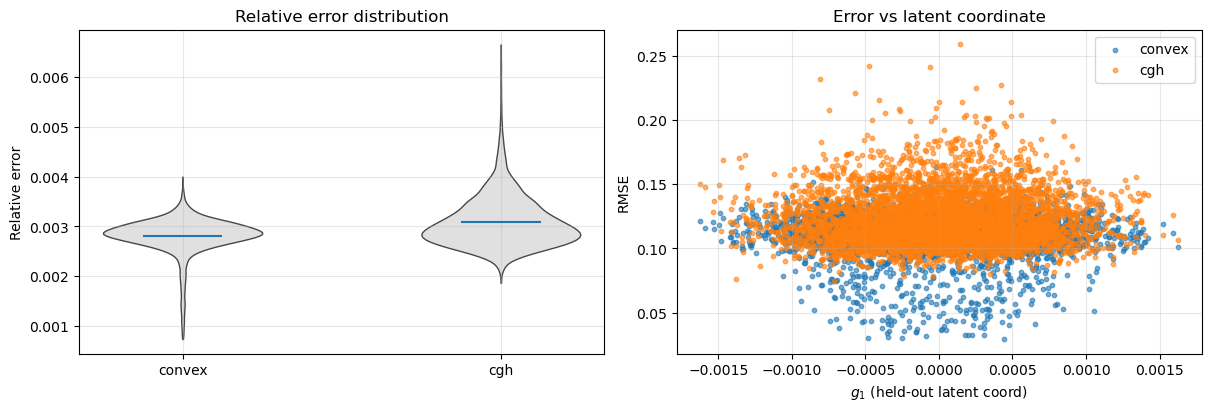

Aggregate hold-out lift metrics across times:
method             RMSE     RelErr        MAE     |Δvol|       Δvol
-------------------------------------------------------------------
convex        9.969e-02  2.361e-03  7.915e-02  4.576e-03  1.901e-04
cgh           2.334e-01  5.278e-03  1.863e-01  8.396e-03 -3.275e-04


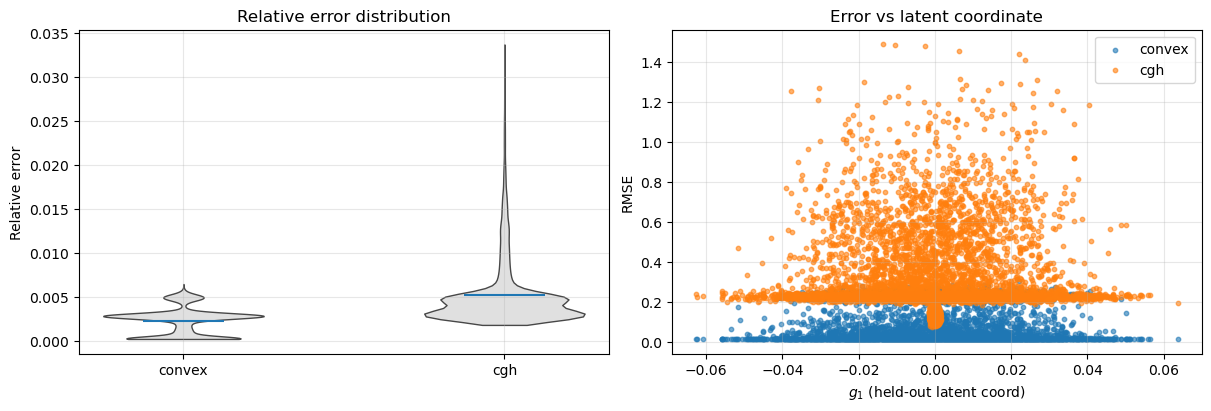

In [30]:
# reload mmsfm.viz (py file) modules to ensure latest versions are used
import importlib
import mmsfm.viz
importlib.reload
import importlib
import mmsfm.viz
importlib.reload(mmsfm.viz)
from mmsfm.viz import plot_field_comparisons, plot_error_statistics
print("Reloaded mmsfm.viz")

# --- Step 6: Lift held-out times and compare against ground truth ---
if held_out_times:
    eval_pairs: list[tuple[float, np.ndarray]] = []
    for t in held_out_times:
        matched: Optional[tuple[float, np.ndarray]] = None
        for t_key, frame in held_out_marginals.items():
            if abs(float(t_key) - float(t)) <= lifting_config.time_match_tol:
                matched = (float(t_key), frame)
                break
        if matched is None:
            print(f"No PCA marginal found for held-out time {t:.3f}; skipping.")
            continue
        eval_pairs.append(matched)

    if eval_pairs:
        eval_times = np.array([t for t, _ in eval_pairs], dtype=np.float64)
        eval_times, phi_eval = sample_latent_at_times(
            interpolation,
            eval_times,
            method=pseudo_config.interp_method,
        )
        pseudo_micro_eval = lift_pseudo_latents(
            phi_eval,
            eval_times,
            models,
            tc_embeddings_time,
            all_frames,
            times_arr,
            config=lifting_config,
            lifting_metadata=lifting_metadata,
            training_interpolation=interpolation,
        )
        sample_indices = tuple(idx for idx in lifting_config.plot_samples if idx < all_frames.shape[1])
        if not sample_indices:
            sample_indices = (0,)

        stacked_truth = []
        stacked_g = []
        stacked_preds: Dict[str, List[np.ndarray]] = {name: [] for name in pseudo_micro_eval}

        for i, (t_eval, X_true_pca) in enumerate(eval_pairs):
            print(f"--- Hold-out t={t_eval:.3f} ---")
            X_true_flat = pca_decode(
                X_true_pca,
                components,
                mean_vec,
                explained_variance,
                is_whitened,
                whitening_epsilon,
            )
            imgs_true = to_images(X_true_flat, resolution)

            preds_flat = {
                name: pca_decode(
                    pseudo_micro_eval[name][i],
                    components,
                    mean_vec,
                    explained_variance,
                    is_whitened,
                    whitening_epsilon,
                )
                for name in pseudo_micro_eval
            }
            imgs_preds = {name: to_images(arr, resolution) for name, arr in preds_flat.items()}

            lift_metrics = compute_lift_metrics(
                X_true_flat,
                None,
                None,
                preds_flat["convex"],
                None,
                X_cgh=preds_flat.get("cgh"),
            )
            print_metric_table(lift_metrics)
            plot_field_comparisons(
                imgs_true,
                imgs_preds.get("cgh", imgs_preds["convex"]),
                None,
                imgs_preds["convex"],
                sample_indices=sample_indices,
                imgs_krr=None,
                vmax_mode=lifting_config.vmax_mode,
            )
            plot_error_statistics(lift_metrics, phi_eval[i])

            stacked_truth.append(X_true_flat)
            stacked_g.append(phi_eval[i])
            for name, arr in preds_flat.items():
                stacked_preds[name].append(arr)

        if stacked_truth:
            X_true_all = np.vstack(stacked_truth)
            agg_preds = {name: np.vstack(arrs) for name, arrs in stacked_preds.items() if arrs}
            agg_metrics = compute_lift_metrics(
                X_true_all,
                None,
                None,
                agg_preds["convex"],
                None,
                X_cgh=agg_preds.get("cgh"),
            )
            print("Aggregate hold-out lift metrics across times:")
            print_metric_table(agg_metrics)
            plot_error_statistics(agg_metrics, np.vstack(stacked_g))
    else:
        print("Held-out times provided but no matching PCA marginals; skipping lift comparison.")
else:
    print("No held-out times provided; skipping lift comparison.")

# %% [markdown]
# ## Visualization of Reconstructed Fields
#  
# ## Visualize the fractional PCA intervals and reconstructed fields.

In [23]:
visualize_fractional_pca_intervals(
    all_frames=all_frames,
    times_arr=times_arr,
    frames_aug=frames_aug,
    pseudo_meta=pseudo_meta,
    components=components,
    mean_vec=mean_vec,
    explained_variance=explained_variance,
    is_whitened=is_whitened,
    whitening_epsilon=whitening_epsilon,
    resolution=resolution,
    sample_indices=tuple(range(min(pseudo_config.n_samples_fields, all_frames.shape[1]))),
)


No pseudo entries to visualise.
